![header](./images/slides_header.jpg)

# Overview

The goal of this project is to perform a sentiment analysis of Apple customers, and uncover actionable insight that could be used to optimize a marketing strategy going forward. To achieve this, we built a predictive model using Natural Language Processing (NLP),  that could rate the sentiment of a tweet based on its content. At the end of our analysis, we present the findings of our model and provide concrete recommendations as to how Apple could improve its marketing strategy going forward and ultimately increase customer satisfaction. 

# Business Understanding 

Developing an excellent marketing strategy is crucial for an organization to consistently achieve positive results. To perform effective marketing, companies need to gain a deep understanding of their customers and uncover what matters to them most. The challenge is figuring out how to gain this insight in an efficient manner, and how to consistently implement meaningful change. Fortunately, machine learning provides us with unique and effective tools to perform customer sentiment analysis and guide long-term decision making.

# Data Understanding

For our analysis we utilized the Brands & Product Emotions Dataset, which originally consisted of 9,093 entries. The attributes of this dataset included customer tweets, Apple and Google product types, and customer sentiment. For exploration purposes, we narrowed the dataset to all Apple and Google tweets that had a sentiment attached, which was 3,291 entries.

Imports, downloads and default settings

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
import nltk
from nltk.tokenize import regexp_tokenize, word_tokenize, RegexpTokenizer
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, plot_confusion_matrix

nltk.download('wordnet')
%matplotlib inline

# set style for SNS to get higher resolution pics
sns.set(rc={"figure.dpi":100, 'savefig.dpi':200})
plt.style.use('ggplot')


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\natek\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Read in the data and review it

In [2]:
# Read in the data from file
data = pd.read_csv('data/judge-1377884607_tweet_product_company.csv', encoding='latin1')

In [3]:
## First look at the data
data.head()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [4]:
# Change the column names so it can be more readable
data.columns = ['tweet', 'product', 'sentiment']

In [5]:
## Much cleaner
data.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [6]:
## Quick look at our target values
data.sentiment.value_counts()

No emotion toward brand or product    5389
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [7]:
## Change it so its now positive, negative or neutral
data['sentiment'].replace({'No emotion toward brand or product' : 'Neutral emotion', '''I can't tell''' : 'Neutral emotion'},
                         inplace=True)

In [8]:
data['sentiment'].value_counts()

Neutral emotion     5545
Positive emotion    2978
Negative emotion     570
Name: sentiment, dtype: int64

In [9]:
## Dropping all rows with Null values in it
data = data.dropna(axis=0)

In [10]:
## Reset index for aesthetics 
data.reset_index(drop=True, inplace=True)

In [11]:
data['product'].value_counts()

iPad                               946
Apple                              661
iPad or iPhone App                 470
Google                             430
iPhone                             297
Other Google product or service    293
Android App                         81
Android                             78
Other Apple product or service      35
Name: product, dtype: int64

# Exploratory Data Analysis

## Tweets by topic

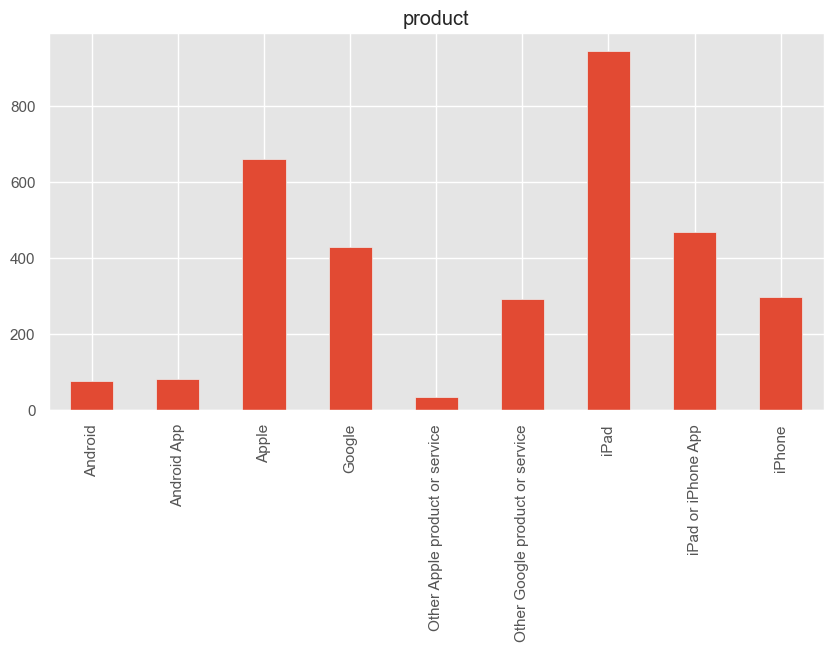

In [12]:
ax = data['product'].value_counts().sort_index() \
    .plot(kind='bar',
         title = 'product',
         figsize=(10,5))

Review Sentiment totals by type

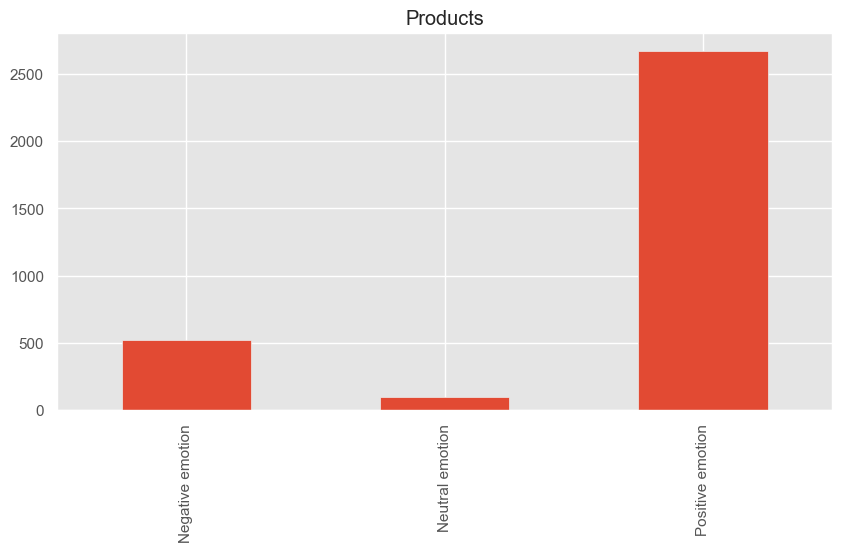

In [13]:
ax = data['sentiment'].value_counts().sort_index() \
    .plot(kind='bar',
         title = 'Products',
         figsize=(10,5))

## Apple vs Google sentiment

In [14]:
## New copy of the dataframe
rq1 = data

In [15]:
## Getting rid of Neutral emotion since we are focusing on Positive vs Negative emotion
rq1 = rq1[rq1['sentiment'] != "Neutral emotion"]

In [16]:
## Split the data frame into the main 2 categories Apple vs Google
rq1_google = rq1[rq1['product'] == "Google"]
rq1_apple = rq1[rq1['product'] == "Apple"]

In [17]:
lul = rq1_apple['sentiment'].value_counts(normalize=True)

In [18]:
lol = rq1_google['sentiment'].value_counts(normalize=True)

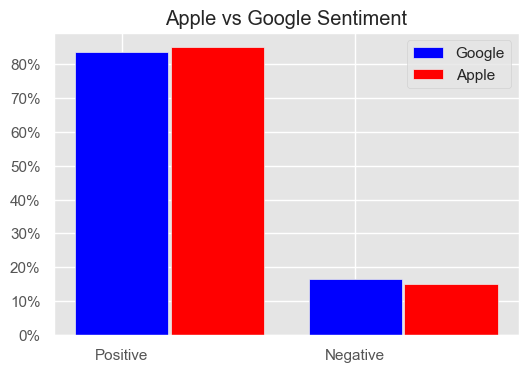

In [19]:
fig, ax = plt.subplots()

ax.bar(x = [0,1], height = lol.values, width=0.4, color='blue')

ax.bar(x = [0.41,1.41], height = lul.values, width=0.4, color='red')

ax.set_xticks([0, 1])
ax.set_xticklabels(['Positive', 'Negative'])
ax.set_title('Apple vs Google Sentiment')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.legend(['Google', 'Apple'])

plt.show()

## Positive vs Negative Apple

In [20]:
## Created new dataframe with Only Apple Products
rq_apple = data[data['product'] == "Apple"]

In [21]:
## Positive Sentiment for apple products
p_rq_apple = data[data['sentiment'] == "Positive emotion"]

In [22]:
## Negative Sentiment for apple products
n_rq_apple = data[data['sentiment'] == "Negative emotion"]

# Modeling

## Basic NLTK preprocessing

In [23]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [24]:
stop_words.update(['link', 'rt', 'quot', 'amp', 'mention'])

In [25]:
def preprocess(tweet):
    tweet = tweet.lower()
    tweet = tokenizer.tokenize(tweet)
    tweet = [word for word in tweet if word not in stop_words]
    tweet = [stemmer.stem(word) for word in tweet]
    return ' '.join(tweet)

In [26]:
data['preprocessed_tweet'] = data['tweet'].apply(preprocess)

In [27]:
data['preprocessed_tweet']

0       wesley83 3g iphon 3 hrs tweet rise_austin dead...
1       jessede know fludapp awesom ipad iphon app lik...
2                   swonderlin wait ipad 2 also sale sxsw
3        sxsw hope year festiv crashi year iphon app sxsw
4       sxtxstate great stuff fri sxsw marissa mayer g...
                              ...                        
3286    pr guy convinc switch back iphon great sxsw co...
3287          papyrus sort like ipad nice lol sxsw lavell
3288    diller say googl tv might run playstat xbox es...
3289    alway use camera iphon b c imag stabil mode su...
3290                                  ipad everywher sxsw
Name: preprocessed_tweet, Length: 3291, dtype: object

## Vectorize 

In [28]:
## Make X into a vector
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data['preprocessed_tweet'])

## Train-test-split the data

In [29]:
## Create my y-axis and Train Test split
y = data['sentiment']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [30]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
rf.score(X_test, y_test)

0.8649468892261002

In [31]:
y_pred = rf.predict(X_test)

## Model

In [32]:
rq_apple =data[data['product'] == "Apple"]

In [33]:
vectorizer = CountVectorizer()

X_apple = vectorizer.fit_transform(rq_apple['preprocessed_tweet'])
y_apple = rq_apple['sentiment']

X_train_a, X_test_a, y_train_a, y_test_a = train_test_split(X_apple, y_apple, test_size=0.2, random_state=42)
rfc = RandomForestClassifier(random_state=42)

In [34]:
rfc.fit(X_train, y_train)
rfc.score(X_test, y_test)

0.8649468892261002

## Hyperparameter tuning with grid search

In [35]:
param_grid = {
    'n_estimators': [100, 120,140], 
    'max_depth': [60, 70],
    'class_weight': [None, 'balanced']
}

In [36]:
rf_tuned = RandomForestClassifier()

In [37]:
grid_search = GridSearchCV(rf_tuned, param_grid, cv=5)

In [38]:
grid_search.fit(X_train_a, y_train_a)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': [60, 70],
                         'n_estimators': [100, 120, 140]})

In [39]:
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'class_weight': 'balanced', 'max_depth': 60, 'n_estimators': 100}
Best score:  0.8428391734052111


In [40]:
## Model after tunning didn't give us a more accurate model, so we are going to keep it as the simple model

rf_tuned = RandomForestClassifier(n_estimators=100, max_depth=70, class_weight='balanced', random_state=42)

In [41]:
rf_tuned

RandomForestClassifier(class_weight='balanced', max_depth=70, random_state=42)

In [42]:
rf_tuned.fit(X_train_a, y_train_a)
rf_tuned.score(X_test_a, y_test_a)

0.8721804511278195

# Final Evaluation

In order to train our model to predict Apple customer sentiment based on future tweets, we needed to narrow our dataset so that it only contained Apple related customer tweets that had a sentiment attached to them. As a result, our final model was built from a dataset that contained 2,751 data entries.  We then preprocessed and vectorized in the same way as our original model, and performed a Grid Search to tune the hyperparameters of the Random Forest Classifier. The Grid Search used a 5-fold-cross-validation and tested various combinations of parameters such as number of estimators, criterion, class weight, etc. After the Grid Search returned the best set of hyperparameters, we ran the final model and achieved an accuracy score of 87.21%. 

# Recommendations
Based on our analysis, we have two concrete recommendations for the Apple marketing team to implement going forward. First- look for more opportunities to do product launches at events. Twitter data indicated that the SXSW event in Austin went very well and generated a lot of positive online buzz. Second- as the iPhone sees improvements in battery life, make sure to strongly highlight these improvements in your advertising. Data indicated that there is a negative perception of the iPhone battery life, and therefore efforts to reduce this perception should bode well

# Next Steps
In the future we’d like to add additional sources of customer sentiment into the analysis, such as data from Facebook and Instagram. The more examples of customer sentiment we have, the better we can predict outcomes and make recommendations. Finally, since customer preferences and attitudes are always evolving, we’d like to update the model and our analysis regularly so that your team can stay on top of trends and perceptions in real-time. Ultimately, we believe these efforts will lead to increased customer satisfaction.